In [87]:
!unzip /content/drive/MyDrive/project_CMIL/Project_CMIL.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/S-2008-000354_PAS_1of2_6455273e435c92704a3d4de5.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/S-1908-009830_PAS_2of2_64551ced435c92704a3c54a1.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/18-142_PAS_2of6_64551bbb435c92704a39933d.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/S-2006-001849_PAS_1of2_64542f6e435c92704a3575e7.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/S-2001-005356_PAS_2of2_64542e76435c92704a33f6dd.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/S-2006-003978_PAS_2of2_645432e2435c92704a38b263.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/18-162_PAS_3of6_64551bfe435c92704a3a61ed.png  
  inflating: /content/data/test/non_globally_sclerotic_glomeruli/S-2103-004763_PAS_2of2_64552861435c92704a3fbe83.png  
  inflating

Before running further cells, change the name of the class folder "globally_sclerotic_glomeruli" to "1-globally_sclerotic_glomeruli" and change the name of the class folder "non_globally_sclerotic_glomeruli" to "0-non_globally_sclerotic_glomeruli". Do the same in your test data folders too. This is because the image_datset_from_directory internally creates mappings based on the aplhabetical order of the names of the folders.

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [101]:
data_dir_with_smote = "/content/CMIL_with_smote/data/after_augmentation"
batch_size = 32
img_height = 224
img_width = 224

In [106]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_with_smote,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5998 files belonging to 2 classes.
Using 4799 files for training.


Run this code Just to make sure that there is no other file or directory than the class folders because the data generators assume the remaining folders also as classes leading to improper training

In [105]:
import shutil
import os
directories = ['/content/CMIL_with_smote/data/after_augmentation/.ipynb_checkpoints']
for directory in directories:
  if os.path.exists(directory):
    # Delete the directory and all its contents
    shutil.rmtree(directory)
    print(f'Directory {directory} has been deleted.')
  else:
      print(f'Directory {directory} does not exist.')

Directory /content/CMIL_with_smote/data/after_augmentation/.ipynb_checkpoints has been deleted.


In [107]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
train_generator = datagen.flow_from_directory(
    data_dir_with_smote,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=123
)

# Get class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Mapping class indices to class names
for class_name, index in class_indices.items():
    print(f"Class '{class_name}' is mapped to label {index}")

Found 4800 images belonging to 2 classes.
Class indices: {'0-non_globally_sclerotic_glomeruli': 0, '1-globally_sclerotic_glomeruli': 1}
Class '0-non_globally_sclerotic_glomeruli' is mapped to label 0
Class '1-globally_sclerotic_glomeruli' is mapped to label 1


In [108]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_with_smote,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5998 files belonging to 2 classes.
Using 1799 files for validation.


In [109]:
class_names = train_ds.class_names
print(class_names)

['0-non_globally_sclerotic_glomeruli', '1-globally_sclerotic_glomeruli']


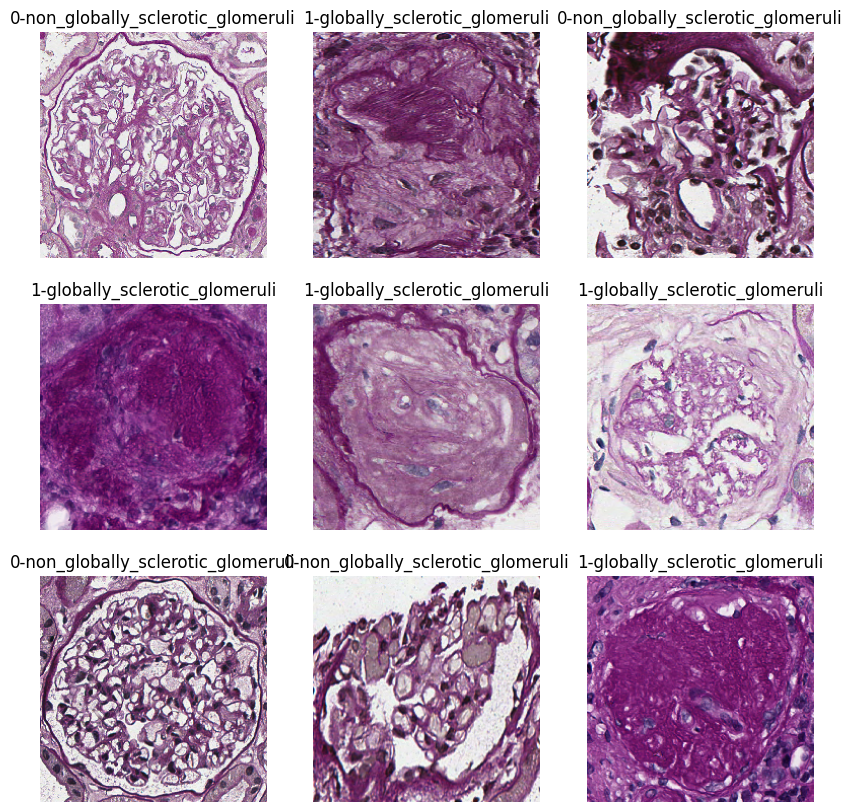

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [111]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [112]:
normalization_layer = layers.Rescaling(1./255)

In [113]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [114]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_val_ds))
first_image = image_batch[1]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [152]:
resnet_model = Sequential()

pretrained_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classes=2
)

for layer in pretrained_model.layers:
        layer.trainable=False

for layer in pretrained_model.layers[-25:]:
    layer.trainable = True


resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(256, activation='relu'))
# resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(1, activation='sigmoid'))

In [153]:
resnet_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [154]:
epochs=5
history = resnet_model.fit(
  normalized_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

Epoch 1/5
150/150 [==============================] - 30s 162ms/step - loss: 0.2927 - accuracy: 0.8806 - val_loss: 2.3899 - val_accuracy: 0.7888
Epoch 2/5
150/150 [==============================] - 23s 153ms/step - loss: 0.1827 - accuracy: 0.9244 - val_loss: 0.2385 - val_accuracy: 0.9144
Epoch 3/5
150/150 [==============================] - 23s 151ms/step - loss: 0.1503 - accuracy: 0.9389 - val_loss: 0.1731 - val_accuracy: 0.9433
Epoch 4/5
150/150 [==============================] - 23s 153ms/step - loss: 0.1236 - accuracy: 0.9512 - val_loss: 0.3598 - val_accuracy: 0.8727
Epoch 5/5
150/150 [==============================] - 23s 154ms/step - loss: 0.1115 - accuracy: 0.9579 - val_loss: 0.1646 - val_accuracy: 0.9561


Text(0.5, 1.0, 'Training and Validation Accuracy')

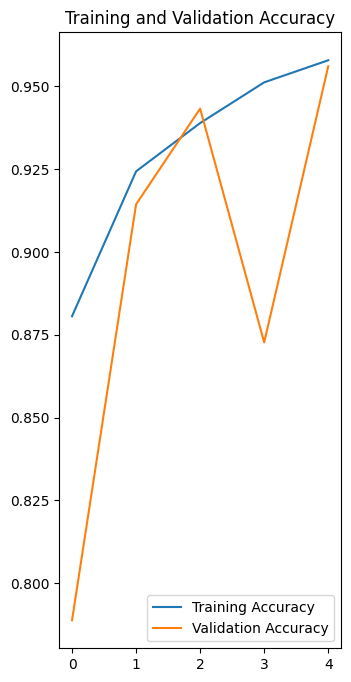

In [155]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

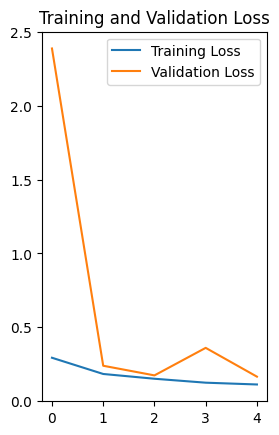

In [156]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run this code Just to make sure that there is no other file or directory than the class folders.

In [157]:
import shutil
import os
directories = ['/content/CMIL_with_smote/data/test/.ipynb_checkpoints']
for directory in directories:
  if os.path.exists(directory):
    # Delete the directory and all its contents
    shutil.rmtree(directory)
    print(f'Directory {directory} has been deleted.')
  else:
      print(f'Directory {directory} does not exist.')

Directory /content/CMIL_with_smote/data/test/.ipynb_checkpoints does not exist.


In [158]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

test_dir = '/content/CMIL_with_smote/data/test'

image_height, image_width = 224, 224  # Change to your model's input size
batch_size = 32

# Create an ImageDataGenerator for loading and preprocessing test images
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',  # or 'categorical' if it's a multi-class problem
    shuffle=False  # Do not shuffle for evaluation
)


Found 863 images belonging to 2 classes.


In [159]:
# Make predictions
y_pred_probs = resnet_model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

# Get true labels
y_true = test_generator.classes


# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

27/27 [==============================] - 29s 1s/step
Accuracy: 0.9049826187717266
Precision: 0.6938775510204082
Recall: 0.8607594936708861
F1 Score: 0.768361581920904
Confusion Matrix:
[[645  60]
 [ 22 136]]


In [160]:
resnet_model.save('/content/drive/MyDrive/CMIL_assignment/my_resnet_model_jun11_r86_a90_p69_with_smote.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
